In [2]:
import transformers as hug
import tensorflow as tf
import pandas as pd
import warnings
import os

from tqdm.auto import tqdm
import numpy as np
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'



In [3]:
tf.config.list_physical_devices('GPU') 

[]

In [4]:
%matplotlib inline
sns.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

In [5]:
def pre_process_input_data(filepath='./data/tweets.csv',encoding='cp1252'): #Change encoding if not on windows
    tweets = pd.read_csv(filepath,encoding=encoding,header=None)
    tweets.columns = ['target','id','date','flag','username','text'] #Change column names to things that make sense
    tweets = tweets.drop(columns=['id','date','flag','username']) #Remove unneeded columns from memory

    tweets = tweets.replace({'target':{0:0,4:1}}) #Dataset has only 0=negative sent, 4=positive sent, remappping to 0,1 respectivly
    return tweets

<Axes: >

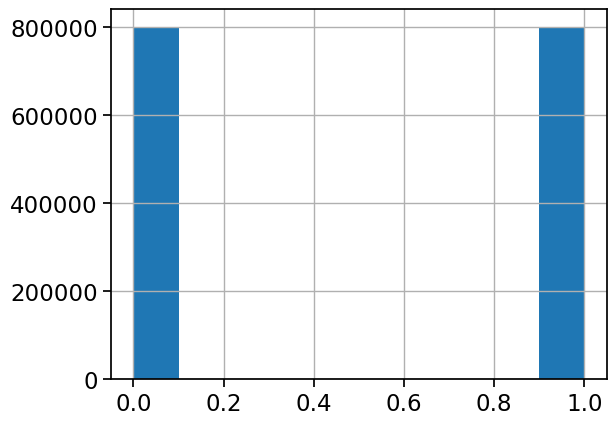

In [6]:
input_data = pre_process_input_data(filepath= "../data/tweets.csv") #Change this to the filepath of the tweets file

input_data['target'].hist()
# input_data.visualize()

## HuggingFace Transformer
<hr>

In [7]:
from transformers import BertTokenizer, TFBertModel
TOKENIZER = BertTokenizer.from_pretrained('bert-base-uncased')
MODEL = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


<Axes: >

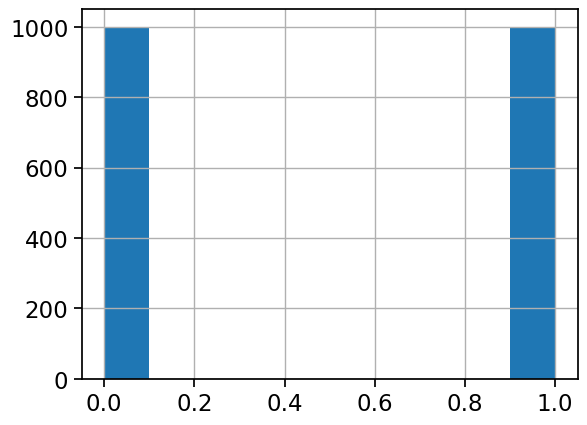

In [8]:
num_samples = 1000
subset = input_data.iloc[:num_samples]
subset = pd.concat([subset,input_data.iloc[-1 * num_samples:]])

# subset = input_data

subset['target'].hist()

In [9]:

# tens,attention = convert_to_encoded("Hello World I am")
def convert_df_to_encoded(df,text_col='text',model=MODEL,tokenizer=TOKENIZER,batch_size=500):

    batches = [(i,min(i+batch_size,len(df))) for i in range(0,len(df),batch_size)] #Split into smaller chunks
    _df = pd.DataFrame()
    max_twt_len = np.max([len(v) for v in df[text_col]])
    print(max_twt_len)
    for lower,upper in tqdm(batches):
        chunk = df.iloc[lower:upper]
        features = tokenizer(chunk[text_col].values.tolist(),padding='max_length', truncation=True, return_tensors='tf',max_length=max_twt_len)
        features = model(**features).last_hidden_state[:,0,:]
        chunk['features'] = features.numpy().tolist()
        _df = pd.concat([_df,chunk])
    return _df
#TODO: PCA compression on vectors down to 250 space for memory reasons


# input_data.sort_values(by='target')

tmp = convert_df_to_encoded(subset)
# tmp = input_data['text'].apply(convert_to_encoded)

157


  0%|          | 0/4 [00:00<?, ?it/s]

#### PCA


In [10]:
x = np.array([x for x in tmp['features']])

In [11]:
x.shape

(2000, 768)

In [12]:
from sklearn.model_selection import train_test_split
vectors = x
targets = tmp['target']
labels = tmp['text']

train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [13]:
train_vectors, val_vectors, train_targets, val_targets, train_labels,val_labels = \
    train_test_split(train_vectors,train_targets,train_labels,test_size = 0.2, random_state=0)

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)
train_vectors = pca.fit_transform(train_vectors)
val_vectors = pca.transform(val_vectors)
test_vectors = pca.transform(test_vectors)


In [15]:
print(f"""
Train Vector Shape: {train_vectors.shape}
Validation Vector Shape: {val_vectors.shape}
Test Vector Shape: {test_vectors.shape}
"""
     )


Train Vector Shape: (1440, 300)
Validation Vector Shape: (360, 300)
Test Vector Shape: (200, 300)



In [16]:
classifier = SGDClassifier(loss='log_loss', random_state=0, max_iter=500)
classifier.fit(train_vectors, train_targets)

SGDClassifier(loss='log_loss', max_iter=500, random_state=0)

In [17]:
accuracy_score(classifier.predict(test_vectors), test_targets)

0.755

In [18]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input, Dropout, Embedding

In [19]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.layers import Layer
import tensorflow as tf

In [20]:
#two layer perceptron
def generateNetwork():
    model = Sequential()
    #embedding layer 
    model.add(tf.keras.Input(shape=(300,)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1,activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-3,
    )
    callbacks = []
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001)) #Early stop
    return model, callbacks
mdl,callbacks = generateNetwork()

In [21]:
def generatSimpleRecurrentNetwork(return_callbacks = True):
    RNN_STATESIZE = 100

    rnns = []
    input_holder = tf.keras.Input(shape=(300,1))
    x = layers.SimpleRNN(RNN_STATESIZE, dropout=0.2, recurrent_dropout=0.2)(input_holder)
    #use a different activation function
    x = layers.Dense(1, activation='relu')(x)
    simple_RNN = Model(inputs=input_holder,outputs=x)

    opt = Adam(lr=0.0001, epsilon=0.0001, clipnorm=1.0)

    callbacks = []
    simple_RNN.compile(loss='binary_crossentropy', 
              optimizer= opt, 
              metrics=['accuracy'])

    #logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    # callbacks.append(tensorboard_callback)

    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001)) #Early stop
    if return_callbacks:
        return simple_RNN, callbacks
    else:
        return simple_RNN
    
simpleRNN,callbacksRNN = generatSimpleRecurrentNetwork()

In [39]:
# 2 Layer CNN


def cnn_seq_noGlove():
        #ensure the input is the 300 dim vector
        sequence_input = Input(shape=(300,1))
        x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(sequence_input)
        x = MaxPooling1D(5)(x)
        x = Dropout(0.5)(x)

        x = Flatten()(x)
        x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
        preds = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(x)

        model = Model(sequence_input, preds)
        callbacksCNN = []
        
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5,)
        model.compile(loss='binary_crossentropy', 
                optimizer=optimizer,
                metrics=['acc'])
        
        callbacksCNN.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001)) #Early stop
        return model, callbacks

cnnMdl,callbacksCNN = cnn_seq_noGlove()

In [40]:
cnnMdl.fit(train_vectors,train_targets,epochs=100,validation_data=(val_vectors,val_targets),callbacks=callbacks)

Epoch 1/100
45/45 [==============================] - 0s 6ms/step - loss: 0.7740 - acc: 0.4826 - val_loss: 0.7344 - val_acc: 0.4472
Epoch 2/100
45/45 [==============================] - 0s 5ms/step - loss: 0.7532 - acc: 0.4931 - val_loss: 0.7192 - val_acc: 0.4389
Epoch 3/100
45/45 [==============================] - 0s 5ms/step - loss: 0.7549 - acc: 0.4861 - val_loss: 0.7069 - val_acc: 0.4583
Epoch 4/100
45/45 [==============================] - 0s 8ms/step - loss: 0.7299 - acc: 0.5076 - val_loss: 0.7011 - val_acc: 0.4917
Epoch 5/100
45/45 [==============================] - 0s 5ms/step - loss: 0.7190 - acc: 0.5188 - val_loss: 0.6922 - val_acc: 0.5222
Epoch 6/100
45/45 [==============================] - 0s 5ms/step - loss: 0.7225 - acc: 0.5083 - val_loss: 0.6873 - val_acc: 0.5194
Epoch 7/100
45/45 [==============================] - 0s 5ms/step - loss: 0.7157 - acc: 0.5076 - val_loss: 0.6824 - val_acc: 0.5417
Epoch 8/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6995 - a

In [24]:
#save my model to my data folder
#cnnMDL is just my CNN model that I trained

cnnMdl.save('../data/cnn_model.h5')
cnnMdl.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 59, 128)          0         
 )                                                               
                                                                 
 dropout_38 (Dropout)        (None, 59, 128)           0         
                                                                 
 flatten (Flatten)           (None, 7552)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               966784    
                                                           

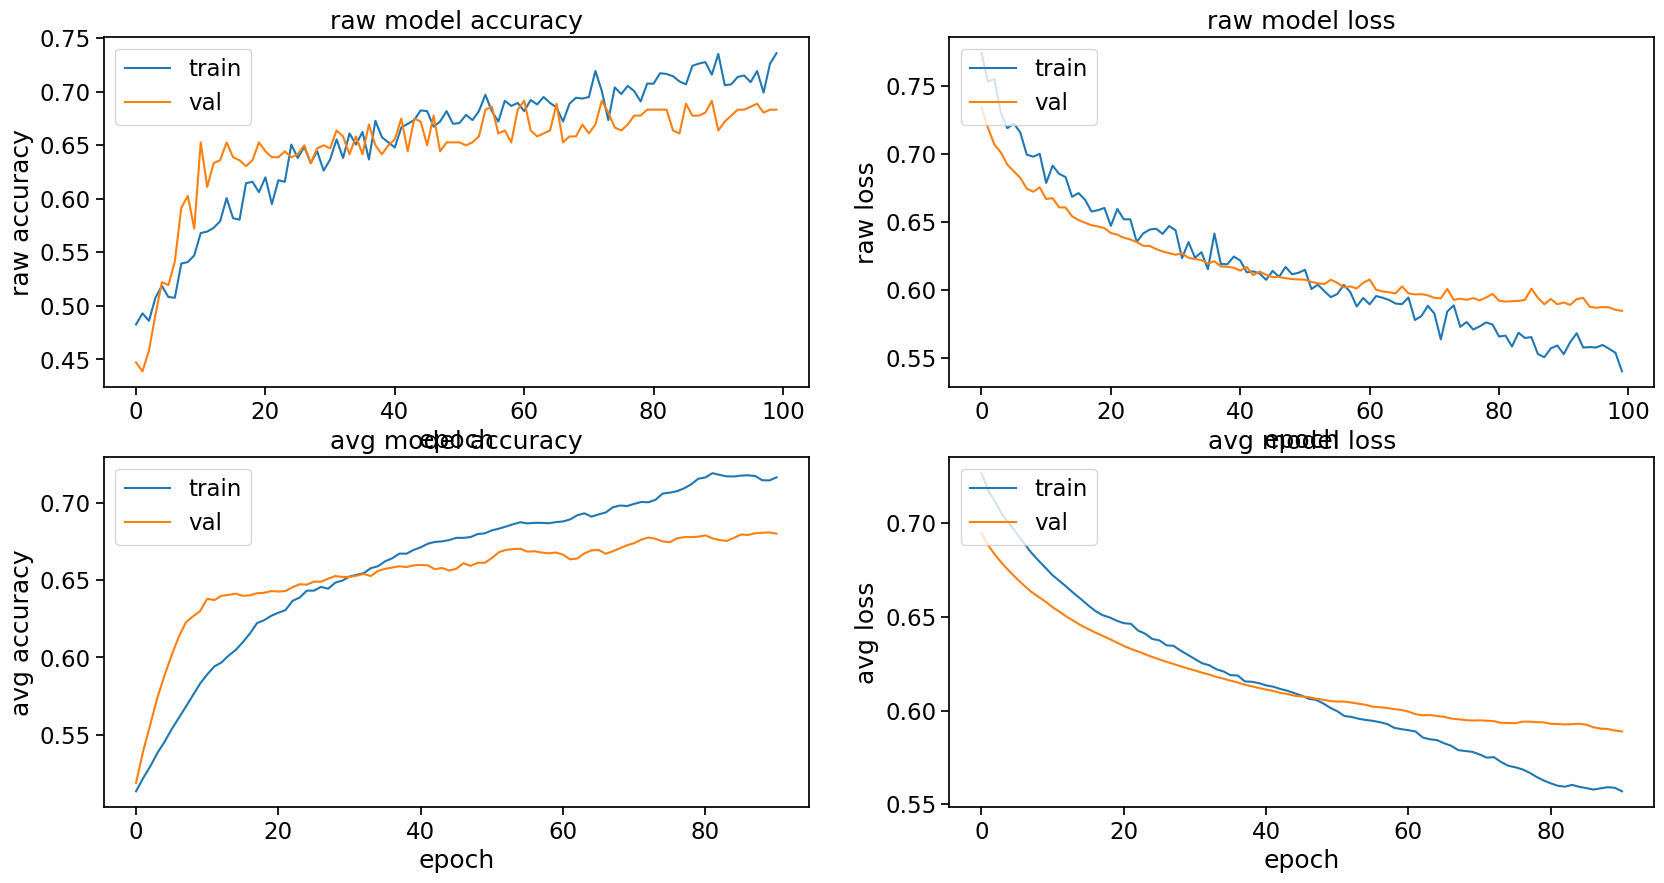

In [41]:
import matplotlib.pyplot as plt

#subplots in a 2 x 2 grid

#plot the accuracy and validation accuracy

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(cnnMdl.history.history['acc'])
plt.plot(cnnMdl.history.history['val_acc'])
plt.title('raw model accuracy')
plt.ylabel('raw accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

#plot the loss and validation loss
plt.subplot(2, 2, 2)
plt.plot(cnnMdl.history.history['loss'])
plt.plot(cnnMdl.history.history['val_loss'])
plt.title('raw model loss')
plt.ylabel('raw loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

#plot the average training and validation accuracy for each epoch for a smoother curve
plt.subplot(2, 2, 3)
plt.plot(np.convolve(cnnMdl.history.history['acc'], np.ones(10)/10, mode='valid'))
plt.plot(np.convolve(cnnMdl.history.history['val_acc'], np.ones(10)/10, mode='valid'))
plt.title('avg model accuracy')
plt.ylabel('avg accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

#plot the average training and validation loss for each epoch for a smoother curve
plt.subplot(2, 2, 4)
plt.plot(np.convolve(cnnMdl.history.history['loss'], np.ones(10)/10, mode='valid'))
plt.plot(np.convolve(cnnMdl.history.history['val_loss'], np.ones(10)/10, mode='valid'))
plt.title('avg model loss')
plt.ylabel('avg loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [26]:
mdl.output_shape


(None, 1)

In [27]:
cnnMdl.output_shape

(None, 1)

In [28]:
simpleRNN.output_shape

(None, 1)

In [29]:
simpleRNN.fit(train_vectors,train_targets,validation_data=(val_vectors,val_targets),epochs=100,callbacks=callbacksRNN)

Epoch 1/100


45/45 [==============================] - 2s 31ms/step - loss: 3.5742 - accuracy: 0.4986 - val_loss: 6.4155 - val_accuracy: 0.5083
Epoch 2/100
45/45 [==============================] - 1s 29ms/step - loss: 2.1899 - accuracy: 0.5021 - val_loss: 0.7795 - val_accuracy: 0.5083
Epoch 3/100
45/45 [==============================] - 1s 28ms/step - loss: 1.6432 - accuracy: 0.5111 - val_loss: 0.8342 - val_accuracy: 0.5083
Epoch 4/100
45/45 [==============================] - 1s 31ms/step - loss: 1.2255 - accuracy: 0.5000 - val_loss: 0.7029 - val_accuracy: 0.5083
Epoch 5/100
45/45 [==============================] - 1s 29ms/step - loss: 0.7895 - accuracy: 0.4924 - val_loss: 0.8680 - val_accuracy: 0.5083
Epoch 6/100
45/45 [==============================] - 1s 29ms/step - loss: 0.7564 - accuracy: 0.4674 - val_loss: 0.6987 - val_accuracy: 0.5000
Epoch 7/100
45/45 [==============================] - 1s 29ms/step - loss: 0.7410 - accuracy: 0.4993 - val_loss: 0.6979 - val_accuracy: 0.5028
Epoch 8/100
45/45 

In [30]:
mdl.fit(train_vectors,train_targets,epochs=200,validation_data=(val_vectors,val_targets),callbacks=callbacks)


Epoch 1/200
45/45 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5646 - val_loss: 0.6282 - val_accuracy: 0.6722
Epoch 2/200
45/45 [==============================] - 0s 2ms/step - loss: 0.6060 - accuracy: 0.6819 - val_loss: 0.5652 - val_accuracy: 0.7806
Epoch 3/200
45/45 [==============================] - 0s 2ms/step - loss: 0.5378 - accuracy: 0.7528 - val_loss: 0.5178 - val_accuracy: 0.7833
Epoch 4/200
45/45 [==============================] - 0s 1ms/step - loss: 0.4845 - accuracy: 0.7889 - val_loss: 0.4852 - val_accuracy: 0.7972
Epoch 5/200
45/45 [==============================] - 0s 848us/step - loss: 0.4514 - accuracy: 0.7986 - val_loss: 0.4630 - val_accuracy: 0.7972
Epoch 6/200
45/45 [==============================] - 0s 874us/step - loss: 0.4133 - accuracy: 0.8306 - val_loss: 0.4491 - val_accuracy: 0.7972
Epoch 7/200
45/45 [==============================] - 0s 809us/step - loss: 0.3915 - accuracy: 0.8389 - val_loss: 0.4419 - val_accuracy: 0.8000
Epoch 8

In [31]:
# accuracy_score(mdl.predict(test_vectors),test_targets)
mdl.evaluate(test_vectors,test_targets)

7/7 [==============================] - 0s 3ms/step - loss: 0.7769 - accuracy: 0.7150


[0.7769032120704651, 0.7149999737739563]

In [32]:
mdl.metrics_names

['loss', 'accuracy']

In [33]:
res = mdl.predict(test_vectors)

7/7 [==============================] - 0s 353us/step


In [34]:
viewer = pd.DataFrame({'predict':res.flatten(),'target':test_targets,'sentence':test_labels})

In [35]:
pd.set_option('max_colwidth', 400)
viewer['diff'] = abs(viewer['predict'] - viewer['target'])
viewer.sort_values(by='diff').tail(30)

,predict,target,sentence,diff
233,0.765846,0,@labelsnotlove my home town. My mammy called all depressd. Pls explain y a parent let their 8yr old child walk alone? Hello? Its 2009!,0.765846
229,0.801120,0,Why oh why was the Red Sox game rained out? I was so looking forward to opening day,0.801120
262,0.810096,0,help me forget 8th april &amp; 13th july!,0.810096
475,0.834605,0,"We've been good. I'm not liking the snow right now, was getting used to the nice Spring-like weather. How about you?",0.834605
1599811,0.150156,1,to be with you,0.849844
1599854,0.143667,1,@WillaRyan At least trees are being spared.,0.856333
384,0.862425,0,Pepperoni rolls in L.A.?: I called Valentino's - they said that they had sausage rolls but no pepperoni rolls http://tinyurl.com/cec5ka,0.862425
353,0.889311,0,@ScoutBuck tons no hay Troll? ahhhh,0.889311
1599858,0.102578,1,"has a day long date with God today, no phones allowed. the world can rage tomorrow; but today, i am safe.",0.897422
842,0.907959,0,just found out that my mum and my adopted auntie are on twitter.. check them out my mum is TessM64 and my awesome as auntie is tania38,0.907959


In [36]:
input_data.iloc[0:30]

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [37]:
input_data.iloc[-30:]

,target,text
1599970,1,Thanks @eastwestchic &amp; @wangyip Thanks! That was just what I was looking for
1599971,1,"@marttn thanks Martin. not the most imaginative interface, but it'll do for now"
1599972,1,@MikeJonesPhoto Congrats Mike Way to go!
1599973,1,http://twitpic.com/7jp4n - OMG! Office Space... I wanna steal it.
1599974,1,"@yrclndstnlvr ahaha nooo you were just away from everyone else! i had to see Kara, she'd die. and yess we aree, ill see you saturday"
1599975,1,"@BizCoachDeb Hey, I'm baack! And, thanks so much for all those kind notes while I was gone. They made me smile at times when I needed it!"
1599976,1,"@mattycus Yeah, my conscience would be clear in that case."
1599977,1,@MayorDorisWolfe Thats my girl - dishing out the &quot;advice&quot;
1599978,1,@shebbs123 i second that
1599979,1,In the garden


In [38]:
#Stolen From Josh SYlvester
# def make_neural_net_no_sentiment():
#     # Create the model
#     model = keras.Sequential([
#         layers.Dense(units=128, activation='relu'),
#         layers.Dense(units=64, activation='relu'),
#         layers.Dense(units=1, activation='sigmoid')
#     ])

#     reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                                 patience=4, min_lr=0.000001, verbose=1)
#     early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001)

#     callbacks = [early_stop, reduce_lr]
#     optimizer = tf.keras.optimizers.Adam(
#         learning_rate=1e-3,
#     )

#     # Compile the model
#     model.compile(optimizer=optimizer,
#                 loss='binary_crossentropy',
#                 metrics=['accuracy'])

#     return model, callbacks